### RFM模型再思考
1.M应该使用平均金额而不是总额
    - 一是因为总额=平均金额\*消费频次（F），所以总额实际上与F高度相关，按照分类维度的选择标准，三个维度之间最好相关性较弱，否则有维度就是多余的。而且，平均金额某种程度上近似于价格的线性函数，而可以被当成是外生变量，这就导致总额与消费频次F之间形成了简单的线性相关，而由于价格的外生性，平均金额更适合用来做划分维度。
    - 二从业务上来看，我们分类关照的重点是高高高类下的重点用户，相比于由高频次堆叠而来高金额用户，模型应该更关注高金额与高频次的高质量用户，后者相比前者来说更应该成为关注重点。而且，第一点提高平均金额近似价格的函数，而对高价的偏好也可以认为是高质量的用户的投射。
    
2.现时-首购的时间维度添加作为enhancement
    添加该维度的考量实际上与上述效应类似，消费频次给定的前提下，时间维度越长显示用户的质量程度更低。当然，更细化可以考虑消费频次的时间分布，例如将时间切为三等分，观察消费频次在其中的分布来判断用户是否存在流失。

In [ ]:
import pandas as pd
import os
import warnings

warnings.filterwarnings('ignore')


In [3]:
df = pd.read_excel('主订单数据集.xlsx')

data = pd.read_excel('主订单数据集.xlsx')
data = data.dropna()


#use quantile to remove outline value
df = data.copy()
top = df['实付金额'].quantile(0.75) + (df['实付金额'].quantile(0.75)-df['实付金额'].quantile(0.25))*3
bottom = df['实付金额'].quantile(0.25) - (df['实付金额'].quantile(0.75)-df['实付金额'].quantile(0.25))*3
df = df.loc[df['实付金额'] <= top,:]


# process buy number
# BuyNum = df['购买数量'].value_counts().reset_index()
# BuyNum.columns = ['BuyNum', 'Order']
# BuyNum['OrderPercent'] = BuyNum['Order']/BuyNum['Order'].sum()
# BuyNum['OrderPercentCumsum'] = BuyNum['OrderPercent'].cumsum()
# BuyNum
#so we can keep BuyNum <=7, which take 99.974%
df = df.loc[df['购买数量'] <= 7, :]


#process 订单状态
df['订单状态'].value_counts()
#only keep sucess
df = df.loc[df['订单状态'] == '交易成功', :]
df.head()

print(len(df))

289519


In [4]:
# extract data
rfm_df = df[['用户ID','付款时间','实付金额']]
rfm_df['付款时间'] = pd.to_datetime(rfm_df['付款时间'])

rfm_df.head()

,用户ID,付款时间,实付金额
0,uid135460366,2023-01-01 09:32:12,166
1,uid135460367,2023-01-01 09:11:50,117
2,uid135460368,2023-01-01 11:49:02,166
3,uid135460369,2023-01-01 12:20:24,77
4,uid135460370,2023-01-01 01:23:15,158


In [5]:
#calculate R
r = rfm_df.groupby('用户ID')['付款时间'].max().reset_index()
r['R'] = (pd.to_datetime('2024-1-1') - r['付款时间']).dt.days
r = r[['用户ID','R']]

In [6]:
#calculate F, and set order in same day as 1
rfm_df['日期标签'] = rfm_df['付款时间'].astype(str).str[:10]

#set order in same day as 1
dup_f = rfm_df.groupby(['用户ID','日期标签'])['付款时间'].count().reset_index()

f = dup_f.groupby('用户ID')['付款时间'].count().reset_index()
f.columns = ['用户ID','F']

f.head()

,用户ID,F
0,uid135460366,1
1,uid135460367,1
2,uid135460368,2
3,uid135460369,2
4,uid135460370,7


In [9]:
#calculate M
sum_m = rfm_df.groupby('用户ID')['实付金额'].sum().reset_index()
sum_m.columns = ['用户ID','总支付金额']
com_m = pd.merge(sum_m,f,left_on = '用户ID',right_on = '用户ID',how = 'inner')

#use mean
com_m['M'] = com_m['总支付金额'] / com_m['F']

com_m.head()

,用户ID,总支付金额,F,M
0,uid135460366,166,1,166.000000
1,uid135460367,117,1,117.000000
2,uid135460368,241,2,120.500000
3,uid135460369,417,2,208.500000
4,uid135460370,1846,7,263.714286


In [11]:
#merge data
rfm = pd.merge(r,com_m,left_on = '用户ID',right_on = '用户ID',how = 'inner')
rfm = rfm[['用户ID','R','F','M']]
rfm_copy = rfm.copy()  

rfm.head()

,用户ID,R,F,M
0,uid135460366,364,1,166.000000
1,uid135460367,364,1,117.000000
2,uid135460368,268,2,120.500000
3,uid135460369,352,2,208.500000
4,uid135460370,198,7,263.714286


In [12]:
#calculate Score of R,F,M
rfm['R-SCORE'] = pd.cut(rfm['R'],bins = [0,30,60,120,180,1000000],labels = [5,4,3,2,1],right = False).astype(float)
rfm['F-SCORE'] = pd.cut(rfm['F'],bins = [1,2,3,4,5,1000000],labels = [1,2,3,4,5],right = False).astype(float)
rfm['M-SCORE'] = pd.cut(rfm['M'],bins = [0,50,100,150,200,1000000],labels = [1,2,3,4,5],right = False).astype(float)

rfm.head()

,用户ID,R,F,M,R-SCORE,F-SCORE,M-SCORE
0,uid135460366,364,1,166.000000,1.0,1.0,4.0
1,uid135460367,364,1,117.000000,1.0,1.0,3.0
2,uid135460368,268,2,120.500000,1.0,2.0,3.0
3,uid135460369,352,2,208.500000,1.0,2.0,5.0
4,uid135460370,198,7,263.714286,1.0,5.0,5.0


In [13]:
rfm['R是否大于均值'] = (rfm['R-SCORE'] > rfm['R-SCORE'].mean()) * 1
rfm['F是否大于均值'] = (rfm['F-SCORE'] > rfm['F-SCORE'].mean()) * 1
rfm['M是否大于均值'] = (rfm['M-SCORE'] > rfm['M-SCORE'].mean()) * 1
rfm['人群数值'] = (rfm['R是否大于均值'] * 100) + (rfm['F是否大于均值'] * 10) + (rfm['M是否大于均值'] * 1)
rfm.head()

,用户ID,R,F,M,R-SCORE,F-SCORE,M-SCORE,R是否大于均值,F是否大于均值,M是否大于均值,人群数值
0,uid135460366,364,1,166.000000,1.0,1.0,4.0,0,0,1,1
1,uid135460367,364,1,117.000000,1.0,1.0,3.0,0,0,0,0
2,uid135460368,268,2,120.500000,1.0,2.0,3.0,0,1,0,10
3,uid135460369,352,2,208.500000,1.0,2.0,5.0,0,1,1,11
4,uid135460370,198,7,263.714286,1.0,5.0,5.0,0,1,1,11


In [14]:
#grouping
def transform_label(x):
    if x == 111:
        label = '重要价值用户'
    elif x == 110:
        label = '消费潜力用户'
    elif x == 101:
        label = '频次深耕用户'
    elif x == 100:
        label = '新用户'
    elif x == 11:
        label = '重要价值流失预警用户'
    elif x == 10:
        label = '一般用户'
    elif x == 1:
        label = '高消费唤回用户'
    elif x == 0:
        label = '流失用户'
    return label
rfm['人群类型'] = rfm['人群数值'].apply(transform_label)
rfm.head()

,用户ID,R,F,M,R-SCORE,F-SCORE,M-SCORE,R是否大于均值,F是否大于均值,M是否大于均值,人群数值,人群类型
0,uid135460366,364,1,166.000000,1.0,1.0,4.0,0,0,1,1,高消费唤回用户
1,uid135460367,364,1,117.000000,1.0,1.0,3.0,0,0,0,0,流失用户
2,uid135460368,268,2,120.500000,1.0,2.0,3.0,0,1,0,10,一般用户
3,uid135460369,352,2,208.500000,1.0,2.0,5.0,0,1,1,11,重要价值流失预警用户
4,uid135460370,198,7,263.714286,1.0,5.0,5.0,0,1,1,11,重要价值流失预警用户


In [54]:
#further analyse
count = rfm['人群类型'].value_counts().reset_index()
count.columns = ['用户类型','人数']
count['人数占比'] = count['人数'] / count['人数'].sum()
count

,用户类型,人数,人数占比
0,频次深耕用户,41704,0.307717
1,流失用户,20169,0.148819
2,高消费唤回用户,19795,0.146059
3,新用户,17234,0.127163
4,重要价值用户,16898,0.124684
5,重要价值流失预警用户,7798,0.057538
6,一般用户,6088,0.044921
7,消费潜力用户,5841,0.043098


In [16]:
rfm['购买总金额'] = rfm['F'] * rfm['M']
mon = rfm.groupby('人群类型')['购买总金额'].sum().reset_index()
mon.columns = ['用户类型','消费金额']
mon['金额占比'] = mon['消费金额'] / mon['消费金额'].sum()
mon

,用户类型,消费金额,金额占比
0,一般用户,1661677.0,0.036504
1,新用户,1756276.0,0.038582
2,流失用户,1822329.0,0.040033
3,消费潜力用户,2075130.0,0.045586
4,重要价值流失预警用户,5500826.0,0.120842
5,重要价值用户,14628227.0,0.321352
6,频次深耕用户,12411298.0,0.272651
7,高消费唤回用户,5665070.0,0.124450


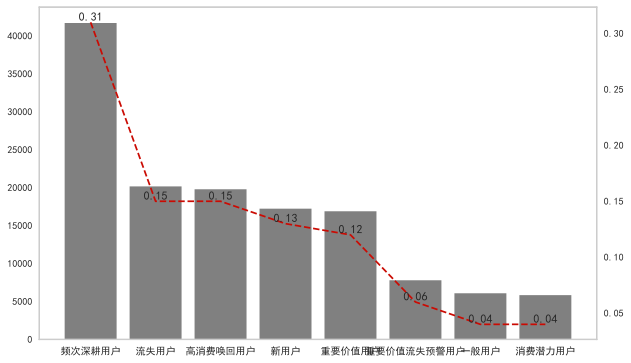

In [55]:
#visualize
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
%config InlineBackend.figure_format = 'svg'
%matplotlib inline


fig = plt.figure(figsize=(10,6))
plt.bar(count['用户类型'], count['人数'], zorder=1, color='grey')
plt.grid(False)

plt.twinx()
count['人数占比'] = count['人数占比'].apply(lambda x:float('%.2f'%x))
plt.plot(count['用户类型'], count['人数占比'],linestyle='--',color='r',zorder=2)
for i, value in enumerate(count['人数占比']):
    plt.text(count['用户类型'][i], value, str(value), ha='center', va='bottom')
plt.grid(False)

plt.xlabel('各类型用户的人数及占比')
plt.xticks(rotation=45)

plt.show()

In [17]:
#enhancement, add column L as today - first buy day

#get first buy day
r_first = rfm_df.groupby('用户ID')['付款时间'].min().reset_index()
r_first['L'] = (pd.to_datetime('2024-1-1') - r_first['付款时间']).dt.days

rfm_v2 = pd.merge(rfm_copy,r_first[['用户ID','L']],left_on = '用户ID',right_on = '用户ID',how = 'inner')

rfm_v2.head()

,用户ID,R,F,M,L
0,uid135460366,364,1,166.000000,364
1,uid135460367,364,1,117.000000,364
2,uid135460368,268,2,120.500000,364
3,uid135460369,352,2,208.500000,364
4,uid135460370,198,7,263.714286,364


In [18]:
#standardize
rfm_v2['R-ZSCORE'] = (rfm_v2['R'] - rfm_v2['R'].mean()) / rfm_v2['R'].std()
rfm_v2['F-ZSCORE'] = (rfm_v2['F'] - rfm_v2['F'].mean()) / rfm_v2['F'].std()
rfm_v2['M-ZSCORE'] = (rfm_v2['M'] - rfm_v2['M'].mean()) / rfm_v2['M'].std()
rfm_v2['L-ZSCORE'] = (rfm_v2['L'] - rfm_v2['L'].mean()) / rfm_v2['L'].std()

rfm_v2.head()

,用户ID,R,F,M,L,R-ZSCORE,F-ZSCORE,M-ZSCORE,L-ZSCORE
0,uid135460366,364,1,166.000000,364,2.806186,-0.405959,-0.358986,2.224516
1,uid135460367,364,1,117.000000,364,2.806186,-0.405959,-0.704197,2.224516
2,uid135460368,268,2,120.500000,364,1.685130,0.326965,-0.679539,2.224516
3,uid135460369,352,2,208.500000,364,2.666054,0.326965,-0.059568,2.224516
4,uid135460370,198,7,263.714286,364,0.867693,3.991589,0.329423,2.224516


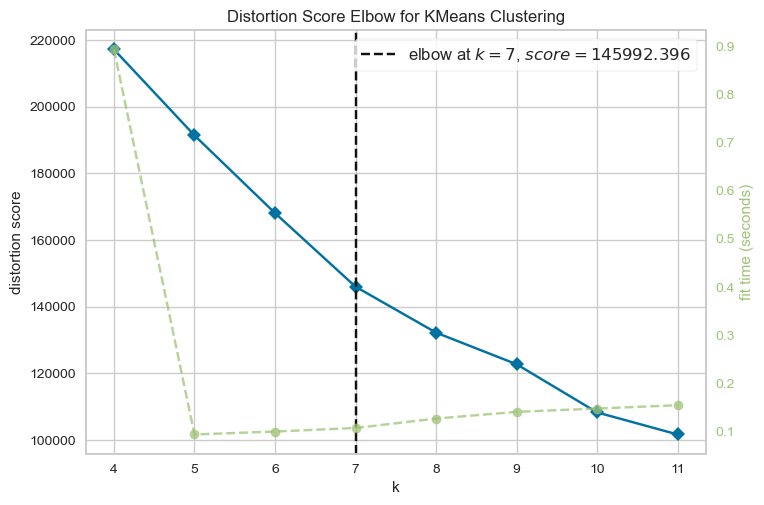

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
#K-means
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


Elbow = KElbowVisualizer(KMeans(),k=(4,12))
use_data = rfm_v2[['R-ZSCORE','F-ZSCORE','M-ZSCORE','L-ZSCORE']]
Elbow.fit(use_data)
Elbow.show()

In [21]:
#so set k=7
kmeans = KMeans(n_clusters = 7,random_state = 0)
y_pred  =  kmeans.fit_predict(rfm_v2[['R-ZSCORE','F-ZSCORE','M-ZSCORE','L-ZSCORE']])
print(y_pred)

[2 2 2 ... 3 3 6]


In [22]:
kmeans_res = pd.DataFrame(kmeans.cluster_centers_,index=['用户类别1','用户类别2','用户类别3','用户类别4','用户类别5','用户类别6','用户类别7'],
                          columns=['R-SCORE', 'F-SCORE', 'M-SCORE', 'L-SCORE'])
kmeans_res

,R-SCORE,F-SCORE,M-SCORE,L-SCORE
用户类别1,-0.094075,-0.301613,-0.425773,-0.302182
用户类别2,-0.364095,1.345559,-0.066282,1.046428
用户类别3,2.088923,-0.232697,0.257029,1.702907
用户类别4,-0.952499,-0.246919,-0.099641,-1.053547
用户类别5,0.990228,-0.224908,-0.589412,0.711893
用户类别6,-0.607131,4.781136,0.002415,1.492473
用户类别7,-0.292804,-0.287258,1.869880,-0.450158
